# Homework 2

In this homework assignment we will perform a simple Monte Carlo geometry tracking task in three dimensions.  Please use Jupyter notebooks for the following exercises.

## General geometry:
Your code should work for a sphere with any center, $(x_c,y_c,z_c)$, and radius, $R$ (you can assume that the sphere always encompasses the source).

Divide the sphere into two hemispheres at the plane $x = x_c$.  Assume the left hemisphere $(x < x_c)$ is filled with a material whose linear attenuation coefficient, $\mu_{-x}$, is 0.1 $\text{cm}^{-1}$.  The right hemisphere $(x > x_c)$ is filled with a material whose linear attenuation coefficient, $\mu_{+x}$, is 0.8 $\text{cm}^{-1}$.  For testing purposes, use a sphere with ($x_c$,$y_c$,$z_c$, R) = (1,2,3,15).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import direct_sampling as ds

## A. Source direction: 

Write a function that will return the direction vector $(u,v,w)$ of the particle at the source.  The function should sample the particle's polar emission angle, $\phi$, relative to the z-axis assuming the distribution below.  Assume the azimuthal angle, $\theta$ , is uniformly distributed between 0 and 2$\pi$.

![](source_dist.png)

In [2]:
def sampleHist(x, p, prn1, prn2):
    """Sample a histogram using a random variable
    
    Parameters
    ----------
    x : Iterable of float
        The domain values of the function
    p : Iterable of float
        The probability values corresponding to domain values
    prn1 : Real
        A first pseudo-random number
    prn2 : Real
        A second pseudo-random number

    Returns
    -------
    float : the sampled value
    """
    # some value checking to start
    if len(x) < 2:
        raise ValueError('There must be at least 2 histogram boundaries')
    if len(x) != len(p) + 1:
        raise ValueError(f'The size of the histogram boundaries {len(x)} must be one larger than the list of probabilities {len(f)}')
        
    out = 0.0
    
    # create an array of bin widths
    widths = np.diff(x) # <-- FILL THIS IN
    
    # create an arrray of areas Homework 1within each bin
    areas = widths * p 
    
    # create a list of bins to be sampled
    bins = np.arange(0,len(p)) # <-- FILL THIS IN
    
    # sample discrete PDF of the bins
    bin = ds.sampleDiscrete( bins, areas , prn1)  # <-- COMPLETE THIS LINE
    
    # sample the uniform PDF defined by that bin
    out = ds.sampleUniform( x[bin], x[bin+1] , prn2)  # <-- COMPLETE THIS LINE
        
    return out

def src_direction():
    """
    Sample the direction of the source in space based on a histogram 
    distribution.
    """
    
    x = np.array([0, 1/4, 3/4, 7/8, 1]) * np.pi
    f = np.array([0.38, 0.23, 0.56, 0.80])
    
    phi = sampleHist(x, f, np.random.rand(), np.random.rand())
    theta = np.random.rand() * 2 * np.pi

    u = np.cos(theta) * np.sin(phi)
    v = np.sin(theta) * np.sin(phi)
    w = np.cos(phi)
    
    return np.array([u,v,w])

## B. Source energy: 

Write a function that will return the energy of the particle by sampling from a Normal distribution with a mean energy of 2.1 MeV and a standard deviation of 0.35 MeV.  

(Note: This technically allows for negative energies [about once in every 4 million]. Reject when a negative energy is sampled.)

In [3]:
def src_energy(mean, std):
    """
    Sample the source energy from a Normal distribution with a mean and std deviation.
    
    parameters
    ----------
    mean : (float) Mean energy of distribution in MeV
    std : (float) standard deviation of distribution in MeV
    
    returns
    -------
    E : (float) a sampled energy in MeV
    """
    
    E = -1

    while E<0:
        xi = np.random.rand()
        eta = np.random.rand()
        E = mean + std * np.sqrt(-2 * np.log(xi))*np.cos(2*np.pi*eta)
    
    return E

## C. Distance to sphere:
Write a function that will return the distance from a point ($x$,$y$,$z$) to the sphere ($x_c$,$y_c$,$z_c$,R) along the direction ($u$,$v$,$w$). 

Note: If the particle is inside the sphere there will be one positive and one negative solution.

$(x-x_c)^2 + (y-y_c)^2 + (z-z_c)^2 - R^2= 0$

$(x,y,z) = (x_o, y_o, z_o) + s (u, v, w)$

$\left[ su + (x_o - x_c) \right]^2$ + $\left[ sv + (y_o - y_c) \right]^2$ + $\left[ sw + (z_o - z_c) \right]^2 - R^2 = 0$

$(u^2 + v^2 + z^2)s^2 + 2\left[ u(x_o-x_c) + v(y_o-y_c) + w(z_o-z_c)\right]s + (x_o-x_c)^2+ (y_o-y_c)^2+ (z_o-z_c)^2 - R^2 = 0$

$s^2 + 2 \vec{u}\cdot(\vec{x_o} - \vec{x_c}) + (\vec{x_o} - \vec{x_c})^2 - R^2 = 0$

$\delta \vec{x} = \vec{x_o} - \vec{x_c}$

$s^2 + 2 \vec{u} \cdot \delta\vec{x} + |\delta\vec{x}|^2 - R^2 = 0$

In [4]:
def dist_sphere(x, u, x_c, R):
    """
    Determine the distance from a point to the boundary of a sphere 
    along a given direction.
    
    All units are in cm.
    
    paramters
    ----------
    x : (numpy array of 3 floats) Coordinates of current particle position
    u : (numpy array of 3 floats) Current particle direction
    x_c : (numpy array of 3 floats) Coordinates of center of sphere
    R : (float) Radius of sphere
    
    returns
    -------
    s : (float) distance to sphere
    """
    s = None

    dx = x-x_c
    
    A = 1
    B = 2 * np.dot(u, dx)
    C = np.dot(dx, dx) - R**2
    
    # number of roots depends on whether D <, = , > 0
    D = B*B - 4*A*C

    if D == 0:   # one root
        s = -B/(2*C)
    elif D > 0: # two roots
        sqrtD = np.sqrt(D) * np.array([-1, 1])
        s = (-B + sqrtD)/(2*A)
        s = np.min(s[s>0])        
    
    return s

## D. Distance to plane:

Write a function that will return the distance from a point ($x$,$y$,$z$) to the plane ($z=z_p$) along the direction ($u$,$v$,$w$). 

Note: The solution will be either positive or negative depending on the position and trajectory of the particle.

In [26]:
def dist_plane(x, u, x_p):
    """
    Determine the distance from a point to a plane 
    along a given direction.
    
    All units are in cm.
    
    paramters
    ----------
    x : (numpy array of 3 floats) Coordinates of current particle position
    u : (numpy array of 3 floats) Current particle direction
    x_p : (float) Location of normal to x-axis
    
    returns
    -------
    s : (float) distance to plane
    """
    
    s = (x_p-x[0])/u[0]
    
    return s

## E. Distance to collision:

Write a function that will return the number of mean free paths to the next collision via random sampling of the linear attenuation equation:  

$$ \Phi = \Phi_o e^{-\Sigma_t x}$$

In [27]:
def dist_collision_mfp():
    """
    Sample the distance to a collision in units of mean free path.
    
    returns
    --------
    n : (float) number of mean free paths to collision
    """
    
    n = -np.log(np.random.rand())
    
    return n

## F. Post-collision direction:

Write a function that will return a post-collision direction vector $(u,v,w)$ using isotropic scattering in the center of mass frame with a target nucleus of mass 3.

In [28]:
def scattering_angle_lab(A):
    """
    Sample the scattering angle in the lab frame for a neutron hitting a nucleus
    of a given mass with isotropic scattering in the center of mass frame.
    
    parameters
    ----------
    A : (float) Mass of the target nucleus
    
    returns
    -------
    phi : (float) scattering angle in the lab frame
    """
    
    mu_c = 2 * np.random.rand() - 1
    
    mu_l = (1 + A * mu_c)/np.sqrt(A*A +2*A*mu_c + 1)
    
    phi = np.arccos(mu_l)
    
    return phi

def update_direction(u_old, phi, theta):
    """
    Determine new direction for a particle that scattered with angles (phi, theta)
    relative to a given direction.
    
    parameters
    -----------
    u_old : (numpy array of 3 floats) Current particle direction
    phi : (float) polar scattering angle
    theta : (float) azimuthal scattering angle
    
    returns
    --------
    u_new : (numpy array of 3 floats) Current particle direction
    """
    
    u, v, w = u_old
    u_new = np.zeros(3)
    mu = np.cos(phi)
    st = np.sin(theta)
    ct = np.cos(theta)
    
    u_new[0] = np.sqrt((1-mu*mu)/(1-w*w) * (u*w*ct - v*st) + u*mu)
    u_new[1] = np.sqrt((1-mu*mu)/(1-w*w) * (v*w*ct - u*st) + v*mu)
    u_new[2] = -np.sqrt((1-w*w)*(1-mu*mu))*ct + w*mu
    
    return u_new
    

## G. Next event: 

Using the outputs of these functions, determine which of the next events occurs:
  - collision
  - particle crosses into other hemisphere
  - particle leaves sphere

In [29]:
def Sigma(x, x_p):
    """
    Determine the cross-section based on the current location.
    
    parameters
    ----------
    x : (numpy array of 3 floats) Coordinates of current particle position
    x_p : (float) Location of normal to x-axis
    """
    
    sigma = np.array([0.1, 0.8])
    
    return sigma[int(x[0] > x_p)]
    
def next_event(s_sphere, s_plane, s_collision):
    """
    Determine the next event that occurs given the distance to each of
    the sphere, the plane and a collision
    
    paramters
    ---------
    s_sphere : (float) distance to the spherical boundary
    s_plane : (float) distance to the plane
    s_collision : (float) distance to the collision
    
    returns
    -------
    event_type : (string) name of event type from ("sphere", "plane", "collision")
    s : (float) distance to event
    """
    s_large = 1000
    
    # check for invalide values of s
    if s_sphere is None:
        s_sphere = s_large
    if s_plane <= 0:
        s_plane = s_large
    
    s_list = np.array([s_sphere, s_plane, s_collision])
    s = min(s_list[s_list>0])
    
    if s == s_sphere:
        event_type = "sphere"
    elif s == s_plane:
        event_type = "plane"
    else:
        event_type = "collision"
    
    return event_type, s

## H. Put it all together: 

Finally, create a loop that updates all the data as necessary to track a particle from its beginning at the point (-1,2,-1) until it leaves the sphere.
Plot: Plot the particle's path as you track it.

In [40]:
# plotting helper functions
def start_plot(x_c, R):
    """
    Start a 3-D plot and put the spherical surface and plane on the plot
    
    parameters
    -----------
    x_c : (numpy array of 3 floats) Coordinates of center of sphere
    R : (float) Radius of sphere

    returns
    ---------
    ax : axis object
    """
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')

    # calculate lattitude and longitude
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j] 

    # generate x,y,z points at all the lat/long combinations
    x = R * np.cos(u) * np.sin(v) + x_c[0]
    y = R * np.sin(u) * np.sin(v) + x_c[1]
    z = R * np.cos(v) + x_c[2]

    # plot a translucent surface
    ax.plot_surface(x, y, z, linewidth=0, alpha=0.15, color="gray")
    ax.plot_surface(x_c[0], y, z, linewidth=1, alpha=0.15, color="purple")
    
    return ax

def plot_event(ax, event_type, x, print_event=False):
    """
    Plot a marker for an event where the color depends on the plot type.
    
    Optionally print the details of the event
    
    parameters
    -----------
    ax : axis object on which to add marker
    event_type : (str) event type
    x : (numpy array of 3 floats) Coordinates of current particle position
    """
    
    color = {"source" : "green", "collision" : "yellow", "plane" : "black", "sphere" : "red"}
    ax.plot(*x, color=color[event_type], marker="x")
    if print_event:
        print(event_type, x, u)

    
def plot_track(ax, x_old, x_new):
    """
    Plot a line indicating a particle track.
    
    parameters
    -----------
    x_old : (numpy array of 3 floats) Coordinates of the beginning of the track
    x_new : (numpy array of 3 floats) Coordinates of the end of the track

    """
    
    pts = np.concatenate([x_old, x_new]).reshape(2,3).T
    ax.plot(*pts, color="black")

<IPython.core.display.Javascript object>


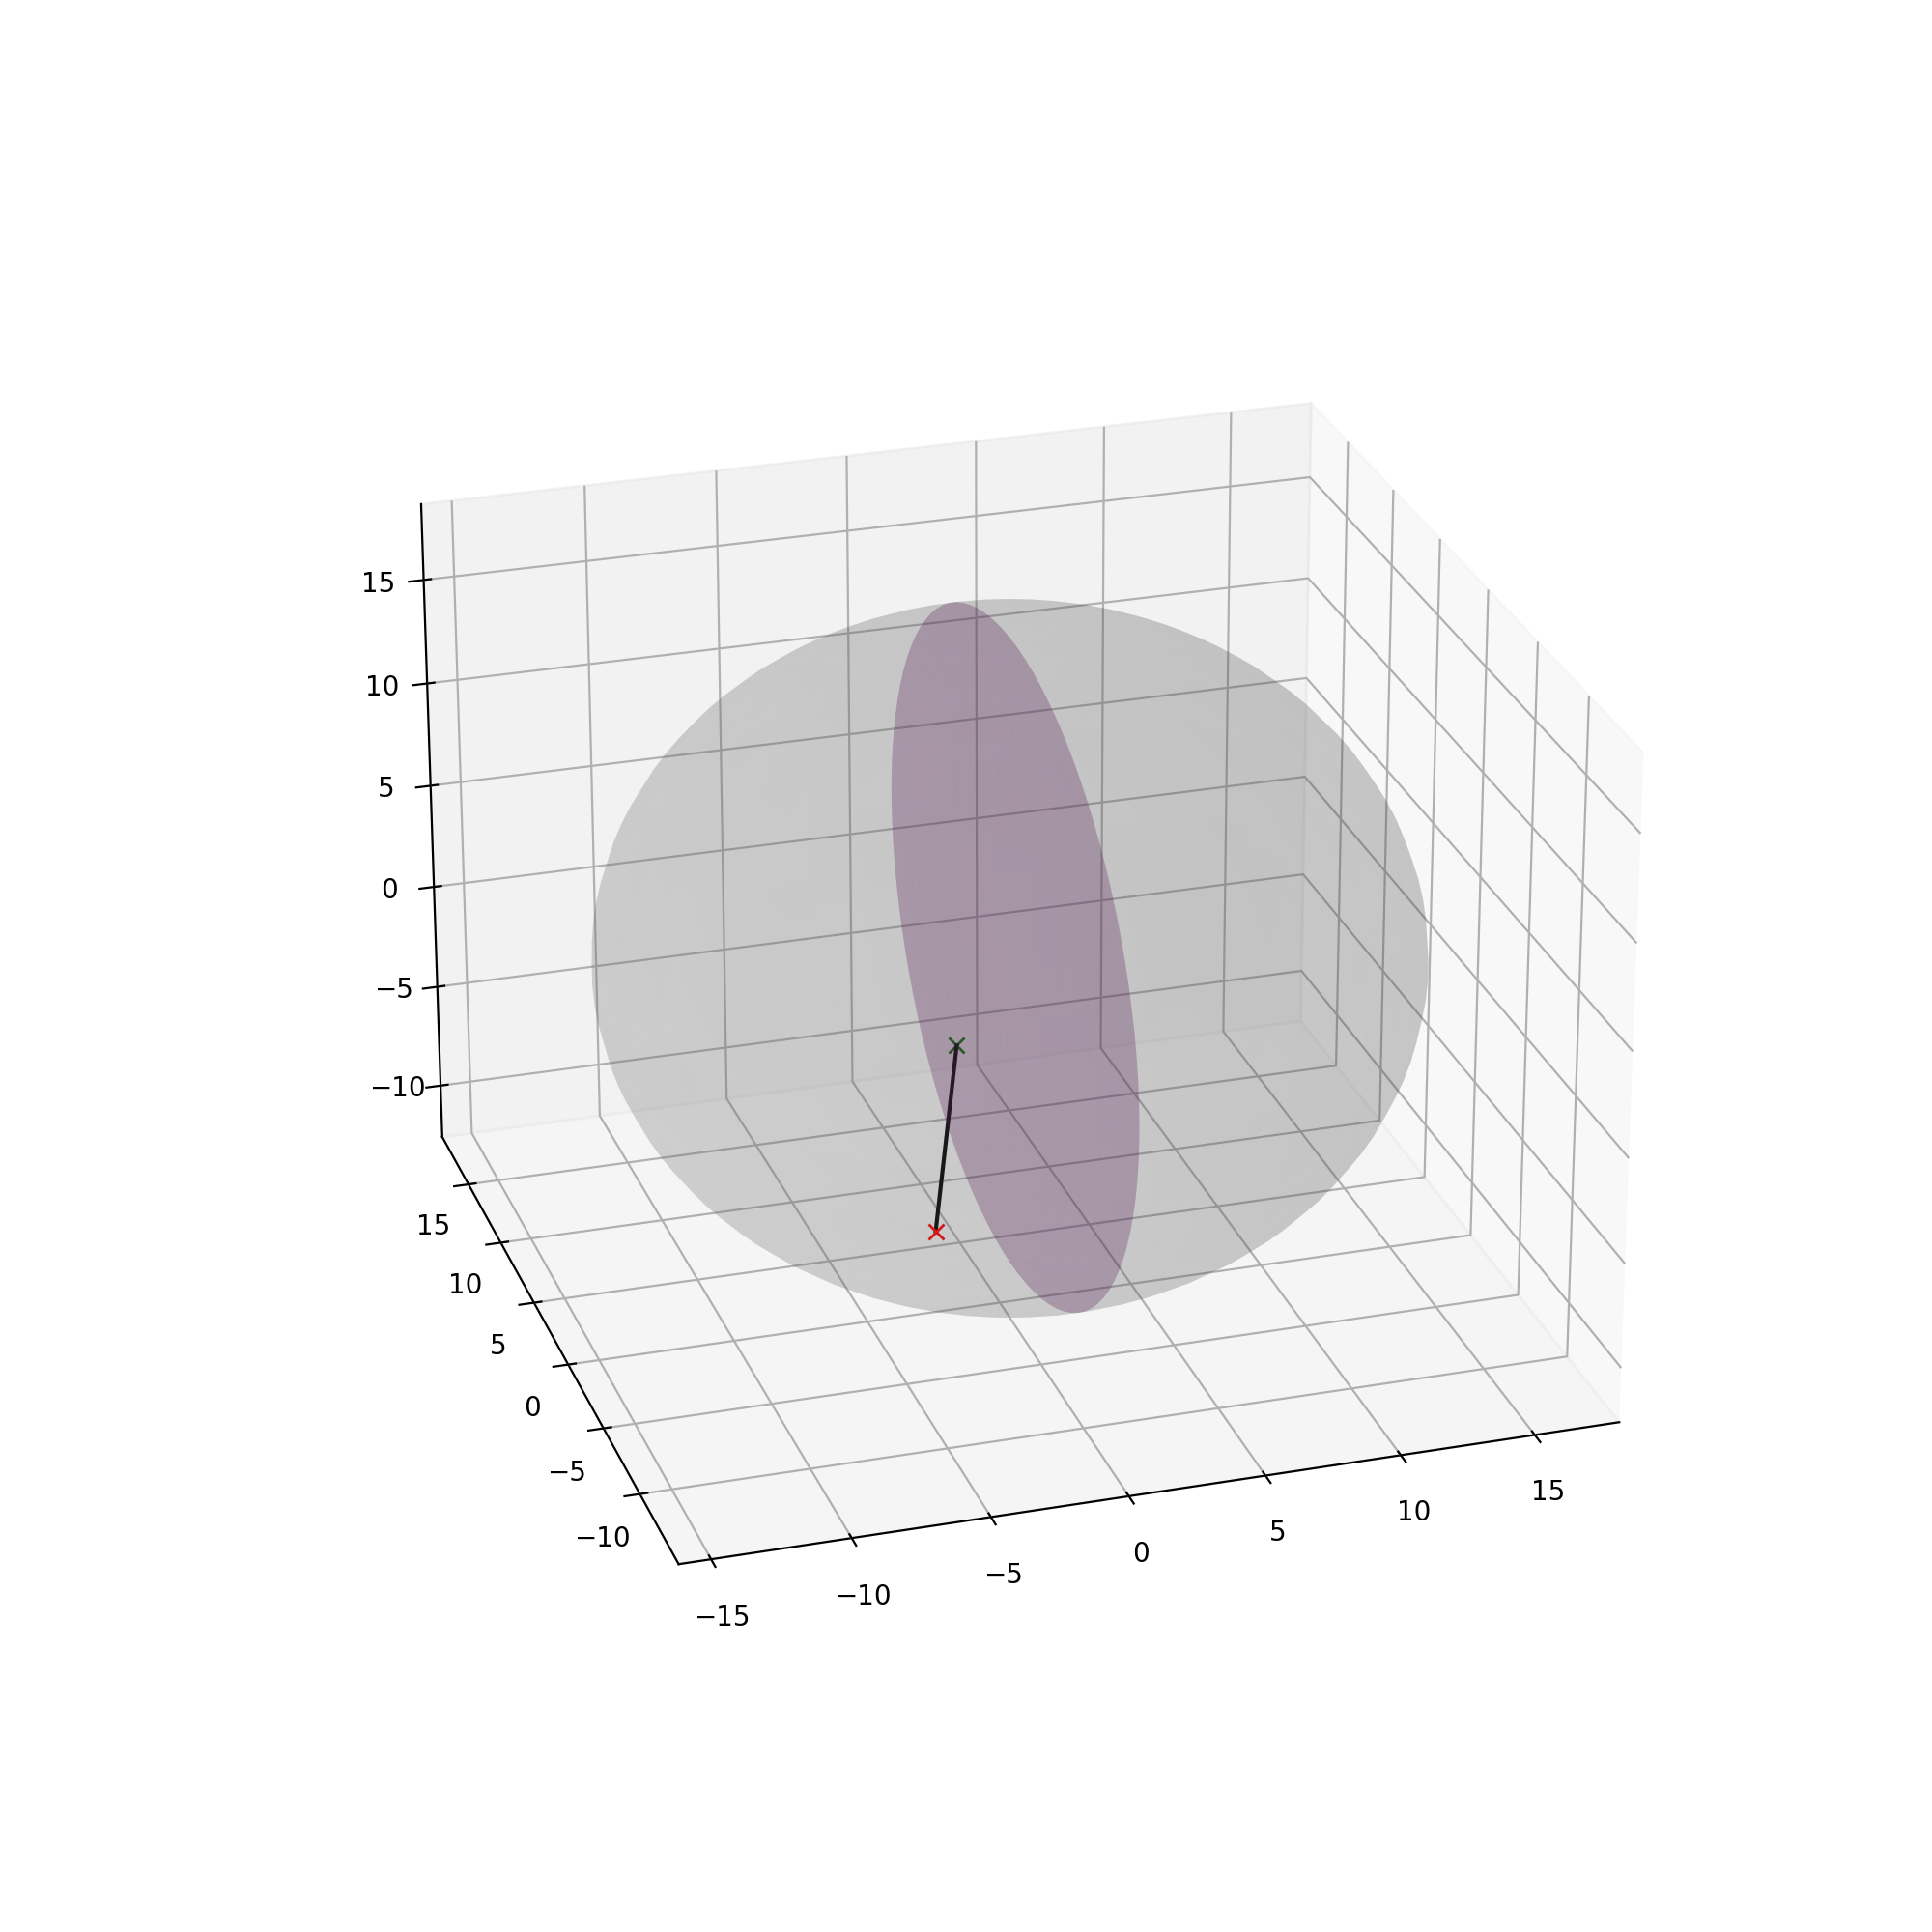

source [-1  2 -1] [-0.00462278  0.23611317 -0.97171457]
sphere [ -1.05058411   4.58363223 -11.63283805] [-0.00462278  0.23611317 -0.97171457]


In [44]:
# setup geometry
x_c = np.array([1,2,3])
R = 15
x_p = x_c[0]

# start plot
ax = start_plot(x_c, R)

# source
event_type = "source"
x = np.array([-1, 2, -1])
u = src_direction()
E = src_energy(2.1, 0.35)
sigma = Sigma(x,x_p)

# sample first distance to collision
n_collision = dist_collision_mfp()

# until we cross the sphere
while event_type != "sphere":
    # plot the last event
    plot_event(ax, event_type, x, True)

    # determine distances to sphere, plane, collision
    s_sphere = dist_sphere(x, u, x_c, R)
    s_plane = dist_plane(x,u,x_p)
    s_collision = n_collision/sigma
    
    # determine event type
    event_type, s = next_event(s_sphere, s_plane, s_collision)

    # advance to new location and plot track
    x_new = x + s * u
    plot_track(ax, x, x_new)
    x = x_new
    
    # act on event
    if event_type == "collision":
        u = src_direction()
        n_collision = dist_collision_mfp()
    elif event_type == "plane":
        n_collision -= s * sigma
        x[0] = x_p
        sigma = Sigma(x+0.01*u, x_p)

plot_event(ax, event_type, x, True)